In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from pathlib import Path

In [2]:
import utils

import importlib
importlib.reload(utils)

<module 'utils' from '/home/tom/Documents/UNT/csce6260/projects/kitti-experiments/rgb/utils.py'>

## Load data

In [3]:
base = Path.home() / "kitti"
train_dir = base / "training"
test_dir = base / "testing"

In [4]:
train_img_dir = train_dir / "image_2"
kitti_images_train = sorted(train_img_dir.glob("*.png"))
test_img_dir = test_dir / "image_2"
kitti_images_test = sorted(test_img_dir.glob("*.png"))
print(f"# of training / testing images: {len(kitti_images_train)} / {len(kitti_images_test)}")

# of training / testing images: 7481 / 7518


In [5]:
train_labels_dir = train_dir / "label_2"
kitti_train_labels = sorted(train_labels_dir.glob("*.txt"))
print("# of training label files: {}".format(len(kitti_train_labels)))
example_label_file = utils.parse_label_file(kitti_train_labels[0])
print(example_label_file)

# of training label files: 7481
[{'type': 'Pedestrian', 'truncated': 0.0, 'occluded': 0, 'alpha': -0.2, 'bbox_2d': (712.4, 143.0, 810.73, 307.92), 'dimensions': (1.89, 0.48, 1.2), 'centroid': (1.84, 1.47, 8.41), 'rotation_y': 0.01}]


## KITTI Object Type Distribution

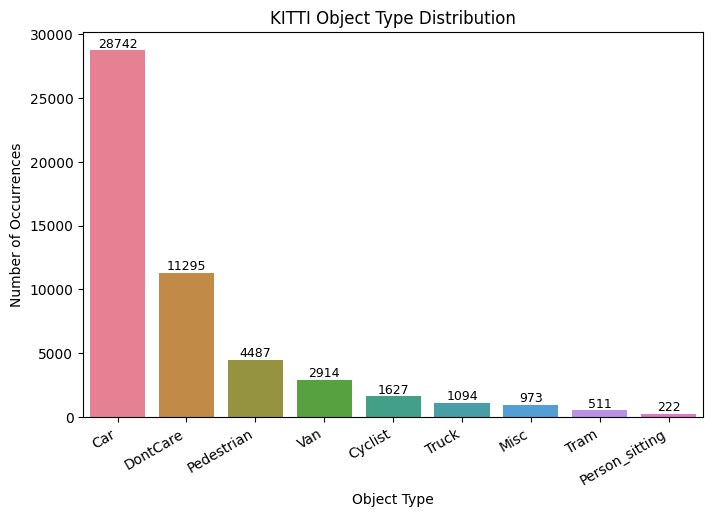

In [6]:
kitti_object_types = Counter()
for label_file in kitti_train_labels:
    parsed_labels = utils.parse_label_file(label_file)
    for label in parsed_labels:
        kitti_object_types[label['type']] += 1

kitti_object_types = dict(sorted(kitti_object_types.items(), key=lambda x: x[1], reverse=True))

object_types = list(kitti_object_types.keys())
occurrences = list(kitti_object_types.values())

palette = sns.color_palette("husl", len(object_types))

plt.figure(figsize=(8, 5))
sns.barplot(
    x=object_types, 
    y=occurrences, 
    hue=object_types,
    palette=palette,
    legend=False
)

for i, v in enumerate(occurrences):
    plt.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=9)

plt.title("KITTI Object Type Distribution")
plt.xlabel("Object Type")
plt.ylabel("Number of Occurrences")
plt.xticks(rotation=30, ha='right')

plt.show()

## Bounding Box Statistics: Average Width and Height


In [7]:
detections = []
for label_file in kitti_train_labels:
    parsed_labels = utils.parse_label_file(label_file)
    for label in parsed_labels:
        detection = (
            label['type'],
            label['bbox_2d'][0],
            label['bbox_2d'][1],
            label['bbox_2d'][2],
            label['bbox_2d'][3]
        )
        detections.append(detection)

df = pd.DataFrame(detections, columns=["class", "x_min", "y_min", "x_max", "y_max"])
df["width"] = df["x_max"] - df["x_min"]
df["height"] = df["y_max"] - df["y_min"]
avg_dims = df.groupby("class")[["width", "height"]].mean().round(2).reset_index()
avg_dims

,class,width,height
0,Car,111.95,66.12
1,Cyclist,55.85,76.89
2,DontCare,53.37,25.65
3,Misc,90.72,74.46
4,Pedestrian,43.82,103.72
5,Person_sitting,83.64,102.28
6,Tram,153.41,104.22
7,Truck,99.72,86.41
8,Van,109.65,83.60


## Bounding Box Statistics: Inferred Difficulty Levels


In [8]:
object_types = []
truncated = []
occluded = []
bbox_height = []
for label_file in kitti_train_labels:
    parsed_labels = utils.parse_label_file(label_file)
    for label in parsed_labels:
        object_types.append(label['type'])
        truncated.append(label['truncated'])
        occluded.append(label['occluded'])
        bbox_height.append(label['bbox_2d'][3] - label['bbox_2d'][1])

df = pd.DataFrame({
    'class': object_types,
    'truncated': truncated,
    'occluded': occluded,
    'bbox_height': bbox_height
})

def compute_difficulty(row):
    if row['occluded'] == 0 and row['truncated'] <= 0.15 and row['bbox_height'] >= 40:
        return "Easy"
    elif row['occluded'] <= 1 and row['truncated'] <= 0.3 and row['bbox_height'] >= 25:
        return "Moderate"
    elif row['occluded'] <= 2 and row['truncated'] <= 0.5 and row['bbox_height'] >= 25:
        return "Hard"
    else:
        return "Unusable"

df["difficulty"] = df.apply(compute_difficulty, axis=1)
counts_df = df.groupby(["class", "difficulty"]).size().unstack(fill_value=0)
counts_df

difficulty,Easy,Hard,Moderate,Unusable
class,,,,
Car,5971,6006,9739,7026
Cyclist,654,96,444,433
DontCare,0,0,3798,7497
Misc,255,178,334,206
Pedestrian,2310,707,1259,211
Person_sitting,39,80,70,33
Tram,139,127,138,107
Truck,253,110,469,262
Van,378,675,920,941


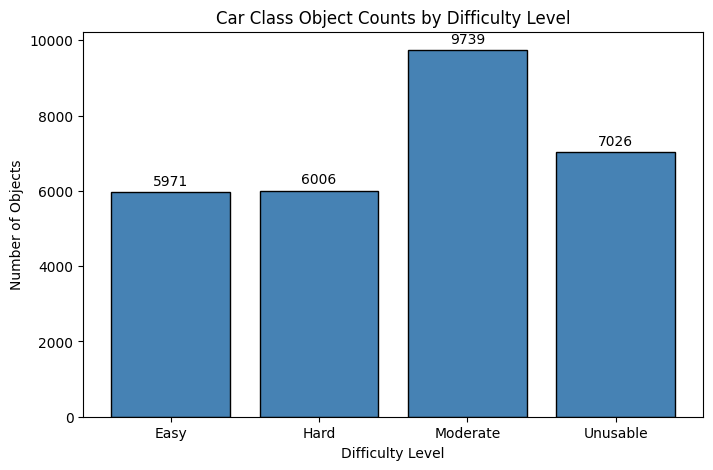

In [9]:
car_counts = counts_df.loc['Car']

labels = car_counts.index.tolist()
values = car_counts.values.tolist()

plt.figure(figsize=(8,5))
bars = plt.bar(labels, values, color="steelblue", edgecolor="black")

for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 100, str(val),
             ha='center', va='bottom', fontsize=10)

plt.title("Car Class Object Counts by Difficulty Level")
plt.xlabel("Difficulty Level")
plt.ylabel("Number of Objects")
plt.show()